In [1]:
# !pip install tensorflow==2.4.1 opencv-python matplotlib
# https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3
#https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3

##### 
model doc: https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3  <br>
My code is based on tutorial https://www.youtube.com/watch?v=SSW9LzOJSus



In [2]:
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt
import cv2

In [3]:
tf.__version__

'2.4.1'

In [12]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_thunder_3.tflite')
interpreter.allocate_tensors()
# preallocate tensors

##### Make Detections


Just Dance video- Not accurate  <br>
Delay- using CPU



In [5]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [6]:
def draw_keypoints(frame, keypoints, confidence):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    for kp in shaped:
        ky, kx, conf = kp
        if conf > confidence:
            cv2.circle(frame,(int(kx),int(ky)), 4,(0,255,0),-1)

In [7]:
# take in 3 keypoints
# formula: https://stackoverflow.com/questions/1211212/how-to-calculate-an-angle-from-three-points
# translate everyting to b coordiate 
def find_angle(frame,keypoints,pt1,pt2,pt3):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    a = np.array(pt1)
    b = np.array(pt2)
    c = np.array(pt3)
    theta = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(theta * 180/np.pi)
    if angle > 180:
        angle = 360 - angle
    return angle

In [8]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [10]:
cap = cv2.VideoCapture(0) #connect the web cam with , or video "file_name"
while cap.isOpened():
    ret, frame = cap.read()  #fram- image
    #input: A frame of video or an image, represented as an 
    #float32 tensor of shape: 192x192x3. Channels order: RGB with values in [0, 255].
    #reshape
    
    img = frame.copy()
#     img = tf.image.resize_with_pad(np.expand_dims(img,axis=0),192,192)
    img = tf.image.resize_with_pad(np.expand_dims(img,axis=0),256,256)
#     frame = tf.image.resize_with_pad(np.array(frame),256,256) # delete 
    frame = cv2.resize(frame,(640,480),interpolation= cv2.INTER_LINEAR)
    input_image = tf.cast(img, dtype = tf.float32)
    
    # setup input and output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # make predictions
    interpreter.set_tensor(input_details[0]['index'],np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]["index"])
#     print(keypoints_with_scores)
    draw_connections(frame, keypoints_with_scores,EDGES,0.2)
    draw_keypoints(frame,keypoints_with_scores,0.2)
    nose = [keypoints_with_scores[0][0][0][1],keypoints_with_scores[0][0][0][0]]
    angle = find_angle(frame,keypoints_with_scores,keypoints_with_scores[0][0][1],keypoints_with_scores[0][0][0],keypoints_with_scores[0][0][2])
    
#     cv2.putText(frame, str(angle),(np.multiply(nose,[640,480]).astype(int)),
#                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0),2)
    cv2.imshow('MoveNet Lightning',frame)
    #exit
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

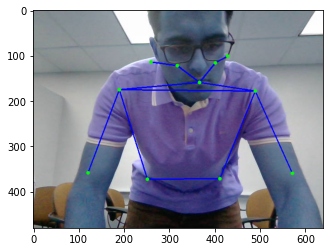

In [11]:
plt.imshow(frame)

In [ ]:
#preprocess input
# img = frame.copy()
# img = tf.image.resize_with_pad(np.expand_dims(img, axis=0),192,192)
# input_image = tf.cast(np.squeeze(img), dtype = tf.float32)
# plt.imshow(input_image)   #to show image change the dtype above to int32

In [ ]:
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()


In [ ]:
interpreter.set_tensor(input_details[0]['index'],np.array(input_image))
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]["index"])
print(keypoints_with_scores) #output yx coordinate


# 
The first two channels of the last dimension represents the yx coordinates (normalized to image frame, i.e. range in [0.0, 1.0]) of the 17 keypoints (in the order of: [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]).



In [ ]:
left_eye = keypoints_with_scores[0][0][1]
left_eye


In [ ]:
np.array(left_eye[:2]*[480,640]).astype(int) #normalize to pixel position

#### Draw Keypoints

In [ ]:
keypoints = keypoints_with_scores
np.squeeze(np.multiply(keypoints,[480,640,1]))

In [ ]:
draw_keypoints(frame,keypoints,0.5)

#### Draw Edges

In [ ]:
find_angle(frame,keypoints[0][0][1],keypoints[0][0][0],keypoints[0][0][2])